## DB Initialisation

In [1]:
import json

with open("dataset_instagram-scraper_2025-04-15_20-06-06-456.json") as f:
    data = json.load(f)



In [2]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["samsung_social"]
client.drop_database("samsung_social")



posts_col = db["posts"]
comments_col = db["comments"]


# Optional: Clear collections before reloading
posts_col.drop()
comments_col.drop()

for post in data:
    post_doc = {
        "_id": post["id"],
        "short_code": post["shortCode"],
        "type": post["type"],
        "caption": post.get("caption"),
        "hashtags": post.get("hashtags", []),
        "url": post["url"],
        "media_url": post.get("displayUrl") or post.get("videoUrl"),
        "likes_count": post.get("likesCount"),
        "comments_count": post.get("commentsCount"),
        "video_view_count": post.get("videoViewCount"),
        "timestamp": post.get("timestamp"),
        "is_sponsored": post.get("isSponsored", False),
        "product_type": post.get("productType")
    }

    # Use upsert to avoid duplication
    posts_col.update_one(
        { "_id": post["id"] },
        { "$set": post_doc },
        upsert=True
    )

    for comment in post.get("latestComments", []):
        user = comment["owner"]

        comments_col.update_one(
            { "_id": comment["id"] },
            {
                "$set": {
                    "post_id": post["id"],
                    "text": comment["text"],
                    "timestamp": comment["timestamp"],
                    "likes_count": comment["likesCount"],
                    "owner_username": comment["ownerUsername"],
                    "owner_verified": user["is_verified"],
                    "owner_profile_pic_url": user["profile_pic_url"],
                    "owner_id": user["id"]
                }
            },
            upsert=True
        )



In [3]:
with open("dataset2_instagram-scraper_2025-04-17_07-07-37-205.json") as f:
    indirect_data = json.load(f)


indirect_col = db["indirect_mentions"]

for post in indirect_data:
    doc = {
        "_id": post["id"],
        "source": "indirect",
        "caption": post.get("caption"),
        "owner_username": post.get("ownerUsername"),
        "owner_id": post.get("ownerId"),
        "is_sponsored": post.get("isSponsored"),
        "location": post.get("locationName"),
        "likes_count": post.get("likesCount"),
        "comments_count": post.get("commentsCount"),
        "url": post.get("url"),
        "video_url": post.get("videoUrl"),
        "media_url": post.get("displayUrl"),
        "product_type": post.get("productType"),
        "timestamp": post.get("timestamp"),
        "video_duration": post.get("videoDuration"),
        "brand_reference": "Samsung"
    }
    indirect_col.update_one({ "_id": doc["_id"] }, { "$set": doc }, upsert=True)

print("Posts collection count:", posts_col.count_documents({}))

Posts collection count: 62


## Sentiment Analysis on Comments and Indirect Posts

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import torch

# Load model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = softmax(outputs.logits, dim=1)
    stars = torch.argmax(scores) + 1
    return stars.item(), scores[0].tolist()
  # integer score, full dist

# ---- Apply to comments ----
for comment in db.comments.find({ "sentiment_stars": { "$exists": False } }):
    text = comment.get("text", "")
    if not text.strip():
        continue

    stars, probs = get_sentiment_score(text)

    db.comments.update_one(
        { "_id": comment["_id"] },
        {
            "$set": {
                "sentiment_stars": stars,
                "sentiment_distribution": probs
            }
        }
    )

print("Comments scored")

# ---- Apply to indirect posts ----
for post in db.indirect_mentions.find({ "sentiment_stars": { "$exists": False } }):
    text = post.get("caption", "")
    if not text.strip():
        continue

    stars, probs = get_sentiment_score(text)

    db.indirect_mentions.update_one(
        { "_id": post["_id"] },
        {
            "$set": {
                "sentiment_stars": stars,
                "sentiment_distribution": probs
            }
        }
    )

print("Indirect mentions scored")


/Users/versaia/Desktop/social_by_design/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Comments scored
Indirect mentions scored


In [5]:
# --- Mean for comments ---
pipeline_comments = [
    { "$match": { "sentiment_stars": { "$exists": True } } },
    { "$group": { "_id": None, "avg_sentiment": { "$avg": "$sentiment_stars" }, "count": { "$sum": 1 } } }
]
comment_result = list(db.comments.aggregate(pipeline_comments))[0]
print(f"Comment Sentiment (avg): {comment_result['avg_sentiment']:.2f}  from {comment_result['count']} comments")

# --- Mean for indirect mentions ---
pipeline_mentions = [
    { "$match": { "sentiment_stars": { "$exists": True } } },
    { "$group": { "_id": None, "avg_sentiment": { "$avg": "$sentiment_stars" }, "count": { "$sum": 1 } } }
]
mention_result = list(db.indirect_mentions.aggregate(pipeline_mentions))[0]
print(f"Indirect Post Sentiment (avg): {mention_result['avg_sentiment']:.2f}  from {mention_result['count']} posts")


Comment Sentiment (avg): 3.00  from 390 comments
Indirect Post Sentiment (avg): 3.42  from 19 posts


#### Clean the text for a better topic modelling

In [6]:
import re
from string import punctuation
import torch

# Simple stopwords list since NLTK might cause issues
STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were',
    'will', 'with', 'the', 'this', 'but', 'they', 'have', 'had', 'what', 'when',
    'where', 'who', 'which', 'why', 'can', 'could', 'should', 'would', 'may',
    'might', 'must', 'shall', 'instagram', 'post', 'photo', 'video', 'follow',
    'like', 'comment', 'share', 'samsung', 'galaxy', 'phone', 'smartphone',
    'via', 'amp', 'rt', 'http', 'https', 'www', 'com', 'co', 'new', 'day',
    'today', 'get', 'got', 'im', 'one', 'going', 'want', 'know', 'time',
    'really', 'see', 'going', 'u', 'ur', 'dont', 'thats', 'cant', 'ive',
    'im', 'youre', 'didnt', 'wont', 'isnt', 'arent', 'wasnt', 'werent'
}

def clean_text(text):
    """Enhanced text cleaning function"""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in STOPWORDS and len(word) > 2]
    # Rejoin the text
    text = ' '.join(words)
    return text.strip()

## Topic Modelling for Comments

In [7]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN



try:
    # Process comments
    print("Processing comments...")
    comment_docs = list(db.comments.find({ "text": { "$exists": True } }))
    filtered_comment_docs = [doc for doc in comment_docs if doc["text"].strip()]
    comment_texts = [clean_text(doc["text"]) for doc in filtered_comment_docs]
    comment_texts = [text for text in comment_texts if text.strip()]

    print(f"Found {len(comment_texts)} valid comments after cleaning")

    if len(comment_texts) >= 5:
        # Load the embedding model
        print("Loading embedding model...")
        embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

        # Configure UMAP with minimal parameters
        umap_model = UMAP(
            n_components=2,
            n_neighbors=3,
            min_dist=0.0,
            metric='cosine',
            random_state=42,
            init='random'
        )

        # Configure BERTopic with minimal parameters
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            min_topic_size=2,
            verbose=True
        )

        # Fit the model
        print("Fitting topic model...")
        topics, probs = topic_model.fit_transform(comment_texts)

        # Update database
        print("Updating database...")
        for i, (doc, text) in enumerate(zip(filtered_comment_docs, comment_texts)):
            if not text:  # Skip empty texts
                continue
                
            topic_id = int(topics[i])
            topic_words = topic_model.get_topic(topic_id)
            
            update_data = {
                "topic_id": topic_id,
                "topic_words": [word for word, _ in topic_words[:5]] if topic_words else []
            }
            
            db.comments.update_one(
                { "_id": doc["_id"] },
                { "$set": update_data }
            )

        # Print summary
        print("\nTopic Analysis Summary:")
        topic_info = topic_model.get_topic_info()
        print(topic_info)
        
        # Print topics
        print("\nDetailed Topics:")
        for topic in topic_info.itertuples():
            if topic.Topic != -1:  # Skip outlier topic
                print(f"\nTopic {topic.Topic} (Count: {topic.Count}):")
                words = [word for word, _ in topic_model.get_topic(topic.Topic)[:5]]
                print("Keywords:", ", ".join(words))

    else:
        print("Not enough comments for meaningful topic modeling")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise

Processing comments...
Found 296 valid comments after cleaning
Loading embedding model...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025-04-18 09:45:07,059 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting topic model...


Batches: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]
2025-04-18 09:45:18,179 - BERTopic - Embedding - Completed ✓
2025-04-18 09:45:18,180 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-18 09:45:25,413 - BERTopic - Dimensionality - Completed ✓
2025-04-18 09:45:25,414 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-18 09:45:25,435 - BERTopic - Cluster - Completed ✓
2025-04-18 09:45:25,438 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-18 09:45:25,509 - BERTopic - Representation - Completed ✓


Updating database...

Topic Analysis Summary:
    Topic  Count                                     Name  \
0      -1     19             -1_music_inches_company_star   
1       0     18              0_apple_лучшие_iphone_about   
2       1      8          1_compren_hacen_pésimo_servicio   
3       2      8            2_kami_belum_pengguna_upgrade   
4       3      8                    3_weak_vfx_omgggg_nhl   
5       4      8            4_release_oneui_ashamed_april   
6       5      7       5_cool_kitchen_refrigerator_fridge   
7       6      7          6_monitor_pixel_experience_dead   
8       7      7            7_washing_machines_repair_how   
9       8      7                 8_días_con_televisor_que   
10      9      7          9_running_wheres_everywhere_ceo   
11     10      7         10_dishwasher_came_spare_charged   
12     11      7          11_nice_referring_yes_marketing   
13     12      6          12_ayıplı_comments_messages_mal   
14     13      6         13_ordered_del

In [8]:
# Update database with topic names instead of topic indices
print("Updating database with topic names...")
for i, (doc, text) in enumerate(zip(filtered_comment_docs, comment_texts)):
    if not text:  # Skip empty texts
        continue

    topic_id = int(topics[i])
    topic_words = topic_model.get_topic(topic_id)
    topic_name = ", ".join([word for word, _ in topic_words[:5]]) if topic_words else "Unknown"

    update_data = {
        "topic_name": topic_name
    }

    db.comments.update_one(
        { "_id": doc["_id"] },
        { "$set": update_data }
    )

print("Database updated with topic names.")

Updating database with topic names...
Database updated with topic names.


## Topic Modelling for Indirect Posts

In [9]:
# Process mentions
print("Processing mentions...")
mention_docs = list(db.indirect_mentions.find({ "caption": { "$exists": True } }))
filtered_mention_docs = [doc for doc in mention_docs if doc["caption"].strip()]
mention_texts = [clean_text(doc["caption"]) for doc in filtered_mention_docs]
mention_texts = [text for text in mention_texts if text.strip()]

print(f"Found {len(mention_texts)} valid mentions after cleaning")

if len(mention_texts) >= 5:
    print("Fitting mention topic model...")
    topics, probs = topic_model.fit_transform(mention_texts)

    print("Updating mentions in database...")
    for i, (doc, text) in enumerate(zip(filtered_mention_docs, mention_texts)):
        if not text:
            continue
        
        topic_id = int(topics[i])
        topic_words = topic_model.get_topic(topic_id)

        update_data = {
            "topic_id": topic_id,
            "topic_words": [word for word, _ in topic_words[:5]] if topic_words else []
        }

        db.indirect_mentions.update_one(
            { "_id": doc["_id"] },
            { "$set": update_data }
        )

    print("\nMention Topic Analysis Summary:")
    topic_info = topic_model.get_topic_info()
    print(topic_info)
else:
    print("Not enough mentions for meaningful topic modeling")


2025-04-18 09:45:25,866 - BERTopic - Embedding - Transforming documents to embeddings.


Processing mentions...
Found 18 valid mentions after cleaning
Fitting mention topic model...


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
2025-04-18 09:45:26,924 - BERTopic - Embedding - Completed ✓
2025-04-18 09:45:26,925 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-18 09:45:26,945 - BERTopic - Dimensionality - Completed ✓
2025-04-18 09:45:26,946 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-18 09:45:26,950 - BERTopic - Cluster - Completed ✓
2025-04-18 09:45:26,953 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-18 09:45:26,967 - BERTopic - Representation - Completed ✓


Updating mentions in database...

Mention Topic Analysis Summary:
   Topic  Count                          Name  \
0      0      9  0_setup_color_camera_scanner   
1      1      6          1_ᵗʰᵉ_ᵃⁿᵈ_ʸᵒᵘʳ_ᶜʳᵃᶠᵗ   
2      2      3      2_درباره_vision_حالا_بود   

                                      Representation  \
0  [setup, color, camera, scanner, ich, iso, tech...   
1  [ᵗʰᵉ, ᵃⁿᵈ, ʸᵒᵘʳ, ᶜʳᵃᶠᵗ, ᶠᵒʳ, ᵁᵗᵃ, ᶜˡᵃˢˢ, ᵇᵒᵒᵏ,...   
2  [درباره, vision, حالا, بود, برنامهها, انگشتان,...   

                                 Representative_Docs  
0  [camera revue super zoom film agfaphoto color ...  
1  [problem hres informаtiоn аbоut mеrcеdеs clr g...  
2  [excellence now obsession freedom, folkestone ...  


## Topic Modelling for brand's own posts

In [10]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
import re
from collections import defaultdict

# Enhanced stopwords for brand content
BRAND_STOPWORDS = {
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he',
    'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were',
    'will', 'with', 'the', 'this', 'but', 'they', 'have', 'had', 'what', 'when',
    'where', 'who', 'which', 'why', 'can', 'could', 'should', 'would', 'may',
    'might', 'must', 'shall', 'instagram', 'post', 'photo', 'video', 'follow',
    'like', 'comment', 'share', 'samsung', 'galaxy', 'phone', 'smartphone',
    'via', 'amp', 'rt', 'http', 'https', 'www', 'com', 'co', 'new', 'day',
    'today', 'get', 'got', 'im', 'one', 'going', 'want', 'know', 'time',
    'really', 'see', 'going', 'click', 'link', 'bio', 'learn', 'more',
    'discover', 'introducing', 'available', 'now', 'check', 'out'
}

def clean_brand_text(text):
    """Enhanced text cleaning function for brand content"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions and hashtags but keep the text
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content without #
    
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in BRAND_STOPWORDS and len(word) > 2]
    
    # Rejoin the text
    text = ' '.join(words)
    
    return text.strip()

try:
    # Fetch all brand posts
    print("Fetching brand posts...")
    posts = list(db.posts.find())
    
    # Prepare content for analysis
    post_texts = []
    post_ids = []
    post_types = defaultdict(int)
    
    for post in posts:
        # Combine caption and type information
        caption = post.get('caption', '')
        post_type = post.get('type', 'unknown')
        post_types[post_type] += 1
        
        # Create enhanced text combining type and caption
        combined_text = f"{post_type} {caption}"
        cleaned_text = clean_brand_text(combined_text)
        
        if cleaned_text.strip():
            post_texts.append(cleaned_text)
            post_ids.append(post['_id'])
    
    print(f"\nContent Type Distribution:")
    for ptype, count in post_types.items():
        print(f"{ptype}: {count} posts")
    
    if len(post_texts) >= 5:
        print(f"\nProcessing {len(post_texts)} posts for topic modeling...")
        
        # Initialize models
        embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
        
        umap_model = UMAP(
            n_components=2,
            n_neighbors=3,
            min_dist=0.0,
            metric='cosine',
            random_state=42,
            init='random'
        )
        
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            min_topic_size=2,
            nr_topics='auto',
            verbose=True
        )
        
        # Fit the model
        topics, probs = topic_model.fit_transform(post_texts)
        
        # Update database with topic information
        print("\nUpdating posts with topic information...")
        for i, (post_id, text) in enumerate(zip(post_ids, post_texts)):
            topic_id = int(topics[i])
            topic_words = topic_model.get_topic(topic_id)
            
            update_data = {
                "content_topic_id": topic_id,
                "content_topic_words": [word for word, _ in topic_words[:5]] if topic_words else [],
                "content_topic_score": float(probs[i]) if probs is not None else None
            }
            
            db.posts.update_one(
                {"_id": post_id},
                {"$set": update_data}
            )
        
        # Print topic analysis
        print("\nTopic Analysis Summary:")
        topic_info = topic_model.get_topic_info()
        print(topic_info)
        
        # Print detailed topic information
        print("\nDetailed Topics and Example Posts:")
        for topic in topic_info.itertuples():
            if topic.Topic != -1:  # Skip outlier topic
                print(f"\nTopic {topic.Topic} (Count: {topic.Count}):")
                words = [word for word, _ in topic_model.get_topic(topic.Topic)[:5]]
                print("Keywords:", ", ".join(words))
                
                # Find example posts for this topic
                example_posts = []
                for i, t in enumerate(topics):
                    if t == topic.Topic and len(example_posts) < 2:
                        example_posts.append(post_texts[i])
                
                if example_posts:
                    print("Example content:")
                    for ex in example_posts:
                        print(f"- {ex[:100]}...")
        
        # Save topic model visualization
        try:
            topic_model.visualize_topics()
            print("\nTopic visualization has been generated.")
        except Exception as viz_error:
            print(f"Could not generate visualization: {str(viz_error)}")
            
    else:
        print("Not enough posts for meaningful topic modeling")

except Exception as e:
    print(f"An error occurred: {str(e)}")
    raise

Fetching brand posts...

Content Type Distribution:
Video: 60 posts
Sidecar: 2 posts

Processing 62 posts for topic modeling...


2025-04-18 09:45:33,465 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]
2025-04-18 09:45:42,695 - BERTopic - Embedding - Completed ✓
2025-04-18 09:45:42,695 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-18 09:45:42,745 - BERTopic - Dimensionality - Completed ✓
2025-04-18 09:45:42,746 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-18 09:45:42,754 - BERTopic - Cluster - Completed ✓
2025-04-18 09:45:42,755 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-18 09:45:42,786 - BERTopic - Representation - Completed ✓
2025-04-18 09:45:42,787 - BERTopic - Topic reduction - Reducing number of topics
2025-04-18 09:45:42,797 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-18 09:45:42,812 - BERTopic - Representation - Completed ✓
2025-04-18 09:45:42,814 - BERTopic - Topic reduction - Reduce


Updating posts with topic information...

Topic Analysis Summary:
   Topic  Count                                     Name  \
0     -1      1      -1_weens_thanks_take_samsungbespoke   
1      0     24                 0_art_ces_neoqled_vision   
2      1     22  1_home_bespoke_bespokeai_samsungbespoke   
3      2      5   2_works_windfree_you_bespokeaiwindfree   
4      3      4     3_register_welcome_bespoke_bespokeai   
5      4      3                 4_qled_pranks_real_safer   
6      5      3                 5_jet_bot_cleaning_clean   

                                      Representation  \
0  [weens, thanks, take, samsungbespoke, bespokea...   
1  [art, ces, neoqled, vision, samsungces, microl...   
2  [home, bespoke, bespokeai, samsungbespoke, you...   
3  [works, windfree, you, bespokeaiwindfree, felt...   
4  [register, welcome, bespoke, bespokeai, , , , ...   
5  [qled, pranks, real, safer, april, quantum, fo...   
6  [jet, bot, cleaning, clean, combo, samsungpart...   

   

## Video and Photo Analysis

Analyzing Samsung's media content...

=== Content Distribution and Engagement Analysis ===

=== Topic Distribution by Content Type ===

=== Temporal Posting Patterns ===


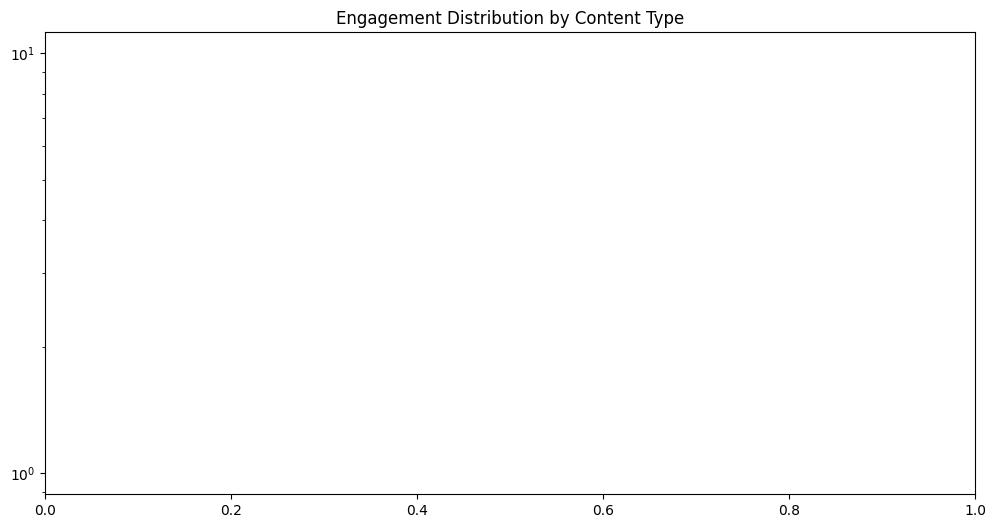


=== Content Strategy Recommendations ===


In [12]:
from collections import defaultdict
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_media_content():
    print("Analyzing Samsung's media content...")
    
    # Get all posts
    posts = list(db.posts.find())
    
    # Initialize containers for analysis
    media_stats = {
        'video': defaultdict(list),
        'sidecar': defaultdict(list),
        'image': defaultdict(list)
    }
    
    # Collect data by content type
    for post in posts:
        content_type = post.get('type', 'unknown')
        if content_type in media_stats:
            # Engagement metrics
            media_stats[content_type]['likes'].append(post.get('likes_count', 0))
            media_stats[content_type]['comments'].append(post.get('comments_count', 0))
            
            # Video specific metrics
            if content_type == 'video':
                media_stats[content_type]['views'].append(post.get('video_view_count', 0))
            
            # Topics and sentiment
            media_stats[content_type]['topics'].append(post.get('content_topic_words', []))
            
            # Timestamp for temporal analysis
            if post.get('timestamp'):
                media_stats[content_type]['timestamps'].append(
                    datetime.fromtimestamp(post['timestamp'])
                )
    
    # Generate summary statistics
    print("\n=== Content Distribution and Engagement Analysis ===")
    for content_type, stats in media_stats.items():
        if stats['likes']:  # Only analyze if we have data
            print(f"\n{content_type.upper()} CONTENT:")
            print(f"Count: {len(stats['likes'])}")
            print(f"Average Likes: {sum(stats['likes']) / len(stats['likes']):,.2f}")
            print(f"Average Comments: {sum(stats['comments']) / len(stats['comments']):,.2f}")
            
            if content_type == 'video' and stats['views']:
                print(f"Average Views: {sum(stats['views']) / len(stats['views']):,.2f}")
                print(f"Average Engagement Rate: {(sum(stats['likes']) / sum(stats['views']) * 100):,.2f}%")
    
    # Topic Analysis by Content Type
    print("\n=== Topic Distribution by Content Type ===")
    for content_type, stats in media_stats.items():
        if stats['topics']:
            topic_words = [word for topic_list in stats['topics'] for word in topic_list]
            word_freq = defaultdict(int)
            for word in topic_words:
                word_freq[word] += 1
            
            print(f"\n{content_type.upper()} Most Common Topics:")
            sorted_topics = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
            for word, freq in sorted_topics[:5]:
                print(f"- {word}: {freq} occurrences")
    
    # Temporal Analysis
    print("\n=== Temporal Posting Patterns ===")
    for content_type, stats in media_stats.items():
        if stats['timestamps']:
            timestamps = pd.Series(stats['timestamps'])
            print(f"\n{content_type.upper()}:")
            print("Posting frequency by day of week:")
            day_counts = timestamps.dt.day_name().value_counts()
            for day, count in day_counts.items():
                print(f"- {day}: {count} posts")
    
    # Generate engagement comparison
    try:
        plt.figure(figsize=(12, 6))
        
        # Prepare data for plotting
        engagement_data = {
            'Content Type': [],
            'Metric': [],
            'Value': []
        }
        
        for content_type, stats in media_stats.items():
            if stats['likes']:
                # Add likes data
                engagement_data['Content Type'].extend([content_type] * len(stats['likes']))
                engagement_data['Metric'].extend(['Likes'] * len(stats['likes']))
                engagement_data['Value'].extend(stats['likes'])
                
                # Add comments data
                engagement_data['Content Type'].extend([content_type] * len(stats['comments']))
                engagement_data['Metric'].extend(['Comments'] * len(stats['comments']))
                engagement_data['Value'].extend(stats['comments'])
        
        # Create DataFrame and plot
        df = pd.DataFrame(engagement_data)
        sns.boxplot(x='Content Type', y='Value', hue='Metric', data=df)
        plt.title('Engagement Distribution by Content Type')
        plt.yscale('log')
        plt.show()
        
    except Exception as e:
        print(f"Could not generate visualization: {str(e)}")
    
    # Return the collected stats for further analysis if needed
    return media_stats

# Run the analysis
media_analysis = analyze_media_content()

# Additional insights about video content
video_stats = media_analysis['video']
if video_stats['views']:
    print("\n=== Detailed Video Performance Analysis ===")
    
    # Calculate view-to-like conversion rate
    conversion_rates = [
        (likes / views * 100) if views > 0 else 0 
        for likes, views in zip(video_stats['likes'], video_stats['views'])
    ]
    
    print(f"View-to-Like Conversion Rate:")
    print(f"- Average: {sum(conversion_rates) / len(conversion_rates):.2f}%")
    print(f"- Highest: {max(conversion_rates):.2f}%")
    print(f"- Lowest: {min(conversion_rates):.2f}%")
    
    # Identify top performing videos
    performance_metrics = list(zip(
        video_stats['views'],
        video_stats['likes'],
        video_stats['comments']
    ))
    
    sorted_by_views = sorted(enumerate(performance_metrics), key=lambda x: x[1][0], reverse=True)
    
    print("\nTop 3 Videos by Views:")
    for i, (idx, (views, likes, comments)) in enumerate(sorted_by_views[:3], 1):
        print(f"{i}. Views: {views:,}, Likes: {likes:,}, Comments: {comments:,}")

# Print recommendations based on the analysis
print("\n=== Content Strategy Recommendations ===")
for content_type, stats in media_analysis.items():
    if stats['likes']:
        avg_engagement = sum(stats['likes']) / len(stats['likes'])
        if content_type == 'video':
            avg_views = sum(stats['views']) / len(stats['views']) if stats['views'] else 0
            print(f"\n{content_type.upper()}:")
            print(f"- Average engagement rate: {(avg_engagement / avg_views * 100 if avg_views > 0 else 0):.2f}%")
            print("Recommendation:", end=" ")
            if avg_views > 0 and (avg_engagement / avg_views) > 0.05:
                print("Continue investing in video content - showing strong engagement")
            else:
                print("Consider optimizing video content strategy for better engagement")
        else:
            print(f"\n{content_type.upper()}:")
            print(f"- Average likes per post: {avg_engagement:,.2f}")
            print("Recommendation:", end=" ")
            if avg_engagement > 1000:
                print(f"Current {content_type} strategy is effective")
            else:
                print(f"Consider reviewing {content_type} content strategy")